Tổng số dòng dữ liệu: 1690
Epoch 1, Loss: 0.0803
Epoch 2, Loss: 0.0422
Epoch 3, Loss: 0.0324
Epoch 4, Loss: 0.0295
Epoch 5, Loss: 0.0280
Epoch 6, Loss: 0.0266
Epoch 7, Loss: 0.0258
Epoch 8, Loss: 0.0253
Epoch 9, Loss: 0.0252
Epoch 10, Loss: 0.0248
Epoch 11, Loss: 0.0245
Epoch 12, Loss: 0.0247
Epoch 13, Loss: 0.0241
Epoch 14, Loss: 0.0241
Epoch 15, Loss: 0.0240
Epoch 16, Loss: 0.0241
Epoch 17, Loss: 0.0239
Epoch 18, Loss: 0.0241
Epoch 19, Loss: 0.0241
Epoch 20, Loss: 0.0239
Epoch 21, Loss: 0.0239
Epoch 22, Loss: 0.0239
Epoch 23, Loss: 0.0238
Epoch 24, Loss: 0.0237
Epoch 25, Loss: 0.0243
Epoch 26, Loss: 0.0236
Epoch 27, Loss: 0.0237
Epoch 28, Loss: 0.0240
Epoch 29, Loss: 0.0241
Epoch 30, Loss: 0.0239
Epoch 31, Loss: 0.0237
Epoch 32, Loss: 0.0238
Epoch 33, Loss: 0.0237
Epoch 34, Loss: 0.0238
Epoch 35, Loss: 0.0237
Epoch 36, Loss: 0.0237
Epoch 37, Loss: 0.0235
Epoch 38, Loss: 0.0241
Epoch 39, Loss: 0.0240
Epoch 40, Loss: 0.0236
Epoch 41, Loss: 0.0237
Epoch 42, Loss: 0.0237
Epoch 43, Loss: 

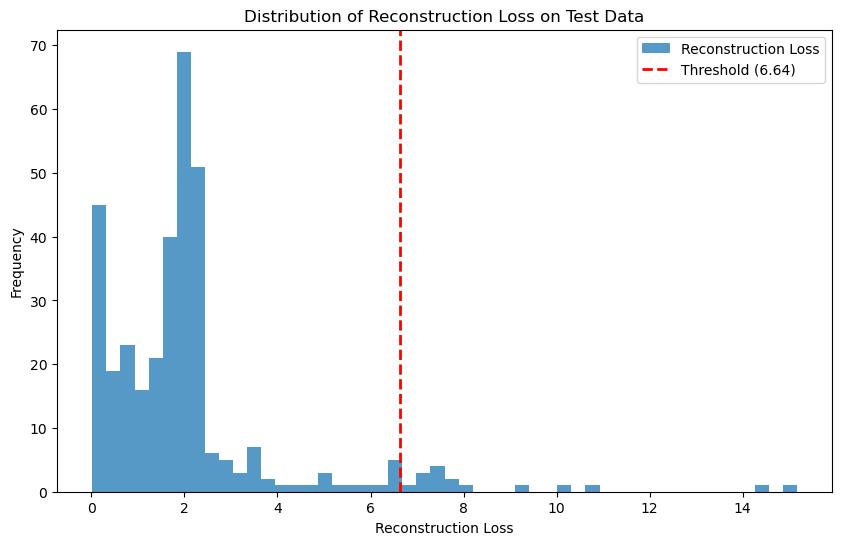

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu từ file CSV mới
data = pd.read_csv('../../data/Chiller.csv')

# In thông tin về dữ liệu
total_samples = len(data)
print(f"Tổng số dòng dữ liệu: {total_samples}")

# 2. Chọn các cột đặc trưng (bỏ qua các cột không cần thiết nếu có)
features = data.drop(columns=['Time'])  # Điều chỉnh cột bỏ đi nếu cần

# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. Lấy 80% dữ liệu để huấn luyện
train_size = int(0.8 * len(scaled_features))
X_train = scaled_features[:train_size]
X_test = scaled_features[train_size:]

# 5. Chuyển đổi sang Tensor cho PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 6. Định nghĩa mô hình VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decoder(z)
        return x_hat, mean, logvar

# 7. Khởi tạo mô hình, loss, và optimizer
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 8. Huấn luyện mô hình VAE
epochs = 50
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=32, shuffle=True)

model.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        recon_loss = nn.MSELoss()(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

# 9. Dự đoán trên tập kiểm tra
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test_tensor)
    reconstruction_loss = torch.mean((X_test_tensor - X_test_pred) ** 2, dim=1).numpy()

# 10. Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)  # Ngưỡng 95%
anomalies = (reconstruction_loss > threshold).astype(int)  # Đánh dấu bất thường nếu lỗi tái tạo lớn hơn ngưỡng

# 11. In ra số lượng điểm bất thường
num_anomalies = np.sum(anomalies)
print(f"Số lượng điểm bất thường phát hiện: {num_anomalies}")

# 12. Vẽ biểu đồ phân phối lỗi tái tạo
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, alpha=0.75, label='Reconstruction Loss')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Loss on Test Data')
plt.legend()
plt.show()